In [1]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sqlalchemy import create_engine
from password import password

In [2]:
protocol = 'postgresql'
username = 'postgres'
password = password
host = 'localhost'
port = 5432
database_name = 'churn_pred'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
connection = engine.connect()

In [3]:
# Loading and displaying a dataset
df = pd.read_sql("SELECT * FROM fact_churn", connection)
df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,international_plan_yes,voice_mail_plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0,1
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0,1,0
2,62,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0,0,0
3,93,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,1,0,0
4,174,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,1,0,0


In [4]:
# Split the data into X_train, X_test, y_train, y_test
X = df.drop(['churn'], axis=1)
y = df['churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.25)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Checking data split in training
X_train.shape

(3750, 17)

In [6]:
# Checking data split in testing
X_test.shape

(1250, 17)

In [7]:
# Retrieving sample of the data
X.sample(5)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_yes,voice_mail_plan_yes
4536,121,0,175.9,87,29.90,225.3,114,19.15,156.2,113,7.03,10.4,3,2.81,2,1,0
4950,57,0,217.1,115,36.91,258.6,92,21.98,173.7,117,7.82,12.6,6,3.40,2,0,0
2406,139,0,211.1,103,35.89,206.9,108,17.59,193.9,70,8.73,5.6,4,1.51,0,0,0
4327,119,0,73.7,66,12.53,160.5,132,13.64,214.2,67,9.64,13.0,6,3.51,3,0,0
3582,103,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,0,1


In [8]:
# Testing Hyper-parameters
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1.0, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [9]:
# Randomized search on hyper parameters
from sklearn.model_selection import RandomizedSearchCV
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose = 2,
                               random_state = 42, n_jobs = 4)
rf_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3000; total time=  17.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3000; total time=  17.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3000; total time=  17.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3000; total time=  18.0s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1.0, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [10]:
rf_random.best_params_

{'n_estimators': 307,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 75,
 'criterion': 'gini',
 'bootstrap': True}

In [11]:
# Tuning Hyper-parameter
rfc = RandomForestClassifier(n_estimators=307,
                             min_samples_split=2,
                             min_samples_leaf=3,
                             max_features='auto',
                             max_depth=75,
                             criterion='gini',
                             bootstrap=True)

In [12]:
# Testing the optimised model
rfc.fit(X_train_scaled, y_train)
thresh = 0.29
pt = np.where(rfc.predict_proba(X_test_scaled)[:,1] > thresh, 1, 0)
print(f"Training Data Score: {rfc.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rfc.score(X_test_scaled, y_test)}")

Training Data Score: 0.9370666666666667
Testing Data Score: 0.88


In [13]:
# Creating a confusion matrix without threshold change
y_pred = rfc.predict(X_test_scaled)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[994,  19],
       [131, 106]])

Text(0.5, 257.44, 'Predicted label')

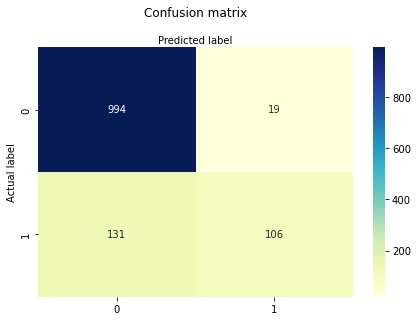

In [14]:
# Creating confusion matrix diagram
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create a heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [15]:
# Creating a confusion matrix on new threshold
confusion_matrix = metrics.confusion_matrix(y_test, pt)
confusion_matrix

array([[964,  49],
       [ 98, 139]])

Text(0.5, 257.44, 'Predicted label')

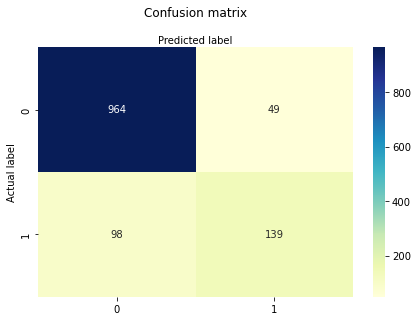

In [16]:
# Creating confusion matrix diagram
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create a heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [17]:
# Create the classification report
target_names = ['churn: no', 'churn: yes']
print(classification_report(y_test, pt, target_names=target_names))

              precision    recall  f1-score   support

   churn: no       0.91      0.95      0.93      1013
  churn: yes       0.74      0.59      0.65       237

    accuracy                           0.88      1250
   macro avg       0.82      0.77      0.79      1250
weighted avg       0.88      0.88      0.88      1250



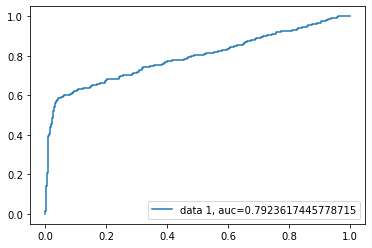

In [18]:
# Create area under the curve graph
y_pred_proba = rfc.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr,label='data 1, auc=' + str(auc))
plt.legend(loc=4)
plt.show()